# Notebook for the Homework-4 of ADM

# EXERCISE [1] Implementing your own Shazam

In [6]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd

import collections
import random
from joblib import Parallel, delayed
from tqdm import tqdm
import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool
import json 
import pandas as pd
from datetime import datetime

from pathlib import Path
from tqdm.notebook import tqdm

# Our utility packages
import hash_utils
import audio_signals_utils
import lsh_utils

## [1.1] Getting your data!

### Global variables

In [2]:
AVAILABLE_CORES = multiprocessing.cpu_count()
pool = ThreadPool(AVAILABLE_CORES)

## Settings

In [3]:
N_TRACKS = 1413
HOP_SIZE = 512
OFFSET = 1.0
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 0 # TODO: to be tuned!

In [4]:
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

## Preprocessing

In [5]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    audio_signals_utils.convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

## Audio signals

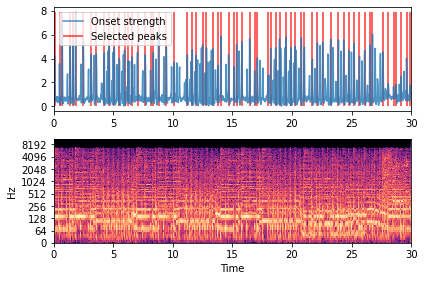

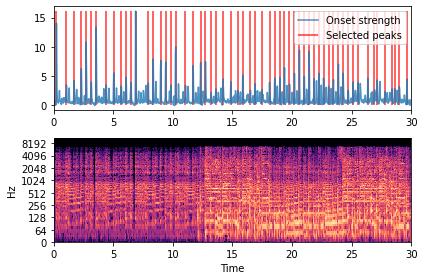

In [6]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = audio_signals_utils.load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    audio_signals_utils.plot_spectrogram_and_peaks(track, sr, peaks, onset_env)
        
        

## [1.2] Fingerprint hashing

For Exercise 1 we decided to take two different approaches:    
Before implementing the LSH procedure we decided to compute minHash signatures in a more classic way with hashing functions, and to evaluate queries with a simple Jaccard Similarity approach.    
After having implemented this we took it as a benchmark for our implementation of the LSH Algorithm.   
Below you can find both implementations


## Shared Constances


In [4]:
hashAmount = 64
hashUpperBound =  2**32-1

## Minhash
----

First, to understand what a Minhash algorithm is, let's introduce the definition of an hash function, which takes an input integer ‘x’:

$h$(x)$=  $(ax + b) % c

This hash function maps an integer x to another integer defined in a range (e.g. 0 to 2^32 -1) and avoids possible collision with other integers. 

The coefficients a and b are randomly chosen integers less than the maximum value of x. c is a prime number slightly bigger than the maximum value of x.

For different choices of a and b, this hash function will produce a different random mapping of the values. So we have the ability to “generate” as many of these random hash functions as we want by just picking different values of a and b.

A Minhash algorithm applies the hash function to every element of an input set (which could be the words inside a document or our sound peaks inside a track) and takes as value the minimum hash value retrieved by all these applications. That value is then inserted in a vector that will be part of the set's signature. 
A signature vector has as many components as the amount of hashfunctions that will be used to compute it. 

Example:
if we define 5 hash functions, our signature will be:   
 [ min $h$(set)1, min $h$(set)2, min $h$(set)3, min $h$(set)4, min $h$(set)5  ]





First let's define some functions to generate random coefficients

Now let's generate the hash components random coefficients...

In [5]:

# this is C, found via lookup from
# http://compoasso.free.fr/primelistweb/page/prime/liste_online_en.php
nextPrimeNumberAfterUpperBound = 4294967311

coefficientsMatrix = hash_utils.generateHashCoefficients(hashAmount,hashUpperBound)
#print(coefficientsMatrix)



Generating random hash function coefficients...


### Extracting Signatures

Finally, let's extract our hashed data!   
For this step, we'll find hash signatures for every track in both our dataset and query set.    
In order to simplify our work, we are also saving all the signatures into two dictionary files:   

**Data** Signatures are saved in `./data/dataSignatures.json`   
**Query** Signatures are saved in `./queries/querySignatures.json`    

This will allow us to load our dataset every time we need to work, instead of reextracting it every time.

In [6]:
query_folder = Path("queries")
query_tracks = query_folder.glob("*.wav")
data_folder = Path("data/mp3s-32k/")
tracks = data_folder.glob("*/*/*.wav")

Let's extract minHash signatures for each track and save it in a dictionary

In [7]:
signatures = {}
# Extract dataset hash signatures
result = pool.map(lambda audio : hash_utils.minHashSignatureIntoDict(audio, signatures, hashAmount, coefficientsMatrix, nextPrimeNumberAfterUpperBound), tracks )

In [9]:
# save dictionary to file
with open('./data/dataSignatures.json', 'w', encoding="utf-8") as out_file:
                json.dump(signatures, out_file)

Let's extract minHash signatures for each query track and save it in a dictionary

In [10]:
query_signatures = {}
# Extract query set hash signatures
result = pool.map(lambda audio : hash_utils.minHashSignatureIntoDict(audio, query_signatures, hashAmount, coefficientsMatrix, nextPrimeNumberAfterUpperBound), query_tracks )

In [11]:
# save dictionary to file
with open('./queries/querySignatures.json', 'w', encoding="utf-8") as out_file:
                json.dump(query_signatures, out_file)

In [13]:
# to resume work from here, you just need to read the dictionaries like so:
query_sigs = open('./queries/querySignatures.json', 'r', encoding='utf-8')
query_signatures = json.load(query_sigs)
data_sigs = open('./data/dataSignatures.json', 'r', encoding='utf-8')
signatures = json.load(data_sigs)

### Performing queries

In order to perform queries we will define some thresholds and see how they affect our results

In [12]:
sure_threshold = 0.95
high_threshold = 0.8
mid_threshold = 0.5
low_threshold = 0.25

# to avoid having to reextract signatures every time,
# we will define a dictionary of all possible query tracks
# mapping them towards query_signatures dictionary values

#### Low Threshold

In [14]:
query_folder = Path("queries")
query_tracks = query_folder.glob("*.wav")
print(f"Checking results with threshold {low_threshold}")
for path in list(query_tracks) :
     hash_utils.find_song_query(path, query_signatures, signatures, hashAmount, low_threshold)

Checking results with threshold 0.25

Your query on track1 has produced these results : 
+-------------+-------+
|    Song     | Score |
+-------------+-------+
| 03-Dream_On |  1.0  |
+-------------+-------+

Your query on track10 has produced these results : 
+-----------------+-------+
|      Song       | Score |
+-----------------+-------+
| 01-Black_Friday |  1.0  |
+-----------------+-------+

Your query on track2 has produced these results : 
+-------------------------+-------+
|          Song           | Score |
+-------------------------+-------+
| 06-I_Want_To_Break_Free |  1.0  |
+-------------------------+-------+

Your query on track3 has produced these results : 
+------------+-------+
|    Song    | Score |
+------------+-------+
| 07-October |  1.0  |
+------------+-------+

Your query on track4 has produced these results : 
+----------------------+-------+
|         Song         | Score |
+----------------------+-------+
| 04-Ob-La-Di_Ob-La-Da |  1.0  |
+--------------

#### Mid Threshold

In [15]:
query_folder = Path("queries")
query_tracks = query_folder.glob("*.wav")
print(f"Checking results with threshold {mid_threshold}")
for path in list(query_tracks) :
     hash_utils.find_song_query(path, query_signatures, signatures, hashAmount, mid_threshold)

Checking results with threshold 0.5

Your query on track1 has produced these results : 
+-------------+-------+
|    Song     | Score |
+-------------+-------+
| 03-Dream_On |  1.0  |
+-------------+-------+

Your query on track10 has produced these results : 
+-----------------+-------+
|      Song       | Score |
+-----------------+-------+
| 01-Black_Friday |  1.0  |
+-----------------+-------+

Your query on track2 has produced these results : 
+-------------------------+-------+
|          Song           | Score |
+-------------------------+-------+
| 06-I_Want_To_Break_Free |  1.0  |
+-------------------------+-------+

Your query on track3 has produced these results : 
+------------+-------+
|    Song    | Score |
+------------+-------+
| 07-October |  1.0  |
+------------+-------+

Your query on track4 has produced these results : 
+----------------------+-------+
|         Song         | Score |
+----------------------+-------+
| 04-Ob-La-Di_Ob-La-Da |  1.0  |
+---------------

#### High Threshold

In [16]:
query_folder = Path("queries")
query_tracks = query_folder.glob("*.wav")
print(f"Checking results with threshold {high_threshold}")
for path in list(query_tracks) :
     hash_utils.find_song_query(path, query_signatures, signatures, hashAmount, high_threshold)

Checking results with threshold 0.8

Your query on track1 has produced these results : 
+-------------+-------+
|    Song     | Score |
+-------------+-------+
| 03-Dream_On |  1.0  |
+-------------+-------+

Your query on track10 has produced these results : 
+-----------------+-------+
|      Song       | Score |
+-----------------+-------+
| 01-Black_Friday |  1.0  |
+-----------------+-------+

Your query on track2 has produced these results : 
+-------------------------+-------+
|          Song           | Score |
+-------------------------+-------+
| 06-I_Want_To_Break_Free |  1.0  |
+-------------------------+-------+

Your query on track3 has produced these results : 
+------------+-------+
|    Song    | Score |
+------------+-------+
| 07-October |  1.0  |
+------------+-------+

Your query on track4 has produced these results : 
+----------------------+-------+
|         Song         | Score |
+----------------------+-------+
| 04-Ob-La-Di_Ob-La-Da |  1.0  |
+---------------

#### Sure Threshold

In [17]:
query_folder = Path("queries")
query_tracks = query_folder.glob("*.wav")
print(f"Checking results with threshold {sure_threshold}")
for path in list(query_tracks) :
     hash_utils.find_song_query(path, query_signatures, signatures, hashAmount, sure_threshold)

Checking results with threshold 0.95

Your query on track1 has produced these results : 
+-------------+-------+
|    Song     | Score |
+-------------+-------+
| 03-Dream_On |  1.0  |
+-------------+-------+

Your query on track10 has produced these results : 
+-----------------+-------+
|      Song       | Score |
+-----------------+-------+
| 01-Black_Friday |  1.0  |
+-----------------+-------+

Your query on track2 has produced these results : 
+-------------------------+-------+
|          Song           | Score |
+-------------------------+-------+
| 06-I_Want_To_Break_Free |  1.0  |
+-------------------------+-------+

Your query on track3 has produced these results : 
+------------+-------+
|    Song    | Score |
+------------+-------+
| 07-October |  1.0  |
+------------+-------+

Your query on track4 has produced these results : 
+----------------------+-------+
|         Song         | Score |
+----------------------+-------+
| 04-Ob-La-Di_Ob-La-Da |  1.0  |
+--------------

## LSH Procedure
----

Now that we've seen a more simple approach let's see what advantages we get by using an LSH approach

In [8]:
query_folder = Path("queries")
query_tracks = query_folder.glob("*.wav")
data_folder = Path("data/mp3s-32k/")
tracks = data_folder.glob("*/*/*.wav")

### Compute the Shingle Matrix

Since we are working with audio tracks, we decided to use **sound peaks** as unique shingles:   
by rounding them to the 3rd decimal digits, we managed to considerably reduce the shingle matrix's amount of rows.   
This led us to having less computational time but also more similar tracks between each other.

In [10]:
t1 = datetime.now()
#pool = ThreadPool(multiprocessing.cpu_count())
#shingle_matrix = pd.concat([pool.map(compile_shingle_dataframe)(tracks)])
shingle_mat = pd.concat(Parallel(n_jobs=AVAILABLE_CORES)(delayed(lsh_utils.extract_track_info_and_shingle_dataframe)(path) for path in tqdm(list(tracks))), axis=1).fillna(0)
t2 = datetime.now()
print(f"computed in {(t2 - t1).total_seconds()} s")

  0%|          | 0/1413 [00:00<?, ?it/s]

computed in 95.672014 s


Let's see how our **Shingle Matrix** came out:

In [11]:
shingle_mat

,aerosmith - 01-Make_It,aerosmith - 02-Somebody,aerosmith - 03-Dream_On,aerosmith - 04-One_Way_Street,aerosmith - 05-Mama_Kin,aerosmith - 06-Write_Me_a_Letter,aerosmith - 07-Movin_Out,aerosmith - 08-Walking_the_Dog,aerosmith - 01-Draw_the_Line,aerosmith - 02-I_Wanna_Know_Why,...,u2 - 01-Zooropa,u2 - 02-Babyface,u2 - 03-Numb,u2 - 04-Lemon,u2 - 05-Stay_Faraway_So_Close_,u2 - 06-Daddy_s_Gonna_Pay_For_Your_Crashed_Car,u2 - 07-Some_Days_Are_Better_Than_Others,u2 - 08-The_First_Time,u2 - 09-Dirty_Day,u2 - 10-The_Wanderer
4.24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.577,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6.883,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.993,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8.881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14.267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10.601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0.737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In order to avoid having to recompute our shingle matrix everytime, we are saving it as a csv.   
Given the huge size of the matrix (500+ MB), this won't be present in our github repository.

In [13]:
shingle_mat.to_csv('./data/shingle_mat.csv', index = True)

This allows us to start working from were we left off...

In [14]:
with open('./data/shingle_mat.csv', 'r') as f:
    shingle_mat = pd.read_csv(f,index_col=0)

### Extract MinHash Signatures

Now that we've extracted our shingles matrix, we will proceed to extract minHash signatures for each track (Which is a column in our shingle matrix)   

In order to do so, these will be our steps:
- define a seed that is used to generate our signature components functions   
- define `hashAmount = 64` amount of hash functions as permutations of our shingle matrix rows   
- save our seed for replication    
- extract a signature matrix applying the hashfunctions to the signature matrix  



In [18]:
# find a random seed to perform matrix permutations
hashSeed = random.randint(0, hashUpperBound)
# save the seed on a file for when you are resuming work
with open('./permutation_seed.txt', 'w') as f:
    f.write(str(hashSeed))

In [8]:
# read the seed to start working from where you left
with open('./permutation_seed.txt', 'r') as f:
    hashSeed = int(f.read())

In [21]:
# generate hashAmount hash functions by preparing shingle matrix indexes random permutations. 
hash_functions = lsh_utils.generate_hash_functions(hashAmount, hashSeed, shingle_mat)
print(f"We've produced {len(hash_functions)} hash functions")

We've produced 64 hash functions


In [23]:
# Dictionary that will contain our signatures. This will use Column as keys, so to form a pandas dataset when we're done computing signatures
signaturesDict = {}
# Multiprocess signatures extraction
result = pool.map(lambda col : lsh_utils.add_sig_to_dict(col, signaturesDict, hash_functions, shingle_mat), shingle_mat.columns)

In [24]:
for key in signaturesDict.keys() :
    if len(signaturesDict[key]) != 64 :
        print(f'error on key {key}')

In [26]:
# Parse the dictionary into a pandas dataframe, this will be our signatures set
signatures_matrix = pd.DataFrame(signaturesDict)
# Save our signatures matrix to a csv to resume work from here.
signatures_matrix.to_csv('./data/signature_mat.csv', index=True)

In [9]:
# Read signature matrix to resume working
with open('./data/signature_mat.csv', 'r') as f:
    signatures_matrix = pd.read_csv(f,index_col=0)

In [27]:
signatures_matrix

,aerosmith - 01-Make_It,beatles - 08-Because,creedence_clearwater_revival - 05-Lookin_Out_My_Back_Door,beatles - 13-Got_To_Get_You_Into_My_Life,creedence_clearwater_revival - 07-Hey_Tonight,dave_matthews_band - 02-Rapunzel,cure - 05-Why_Can_t_I_Be_You_,aerosmith - 02-Somebody,cure - 08-The_Empty_World,dave_matthews_band - 14-Hunger_For_The_Great_Light,...,u2 - 06-Daddy_s_Gonna_Pay_For_Your_Crashed_Car,u2 - 07-Some_Days_Are_Better_Than_Others,u2 - 01-Where_the_Streets_Have_No_Name,u2 - 02-I_Still_Haven_t_Found_What_I_m_Looking_For,u2 - 03-With_or_Without_You,u2 - 04-Bullet_the_Blue_Sky,u2 - 05-Running_to_Stand_Still,u2 - 06-Red_Hill_Mining_Town,u2 - 07-In_God_s_Country,u2 - 08-Trip_Through_Your_Wires
0,207,470,401,4,486,1212,86,37,64,175,...,514,402,3088,173,244,64,4,108,21,69
1,228,74,24,129,56,3,57,548,37,383,...,52,8,1229,136,87,110,105,231,37,41
2,13,230,137,1,186,265,135,353,176,24,...,247,43,84,678,104,248,6,168,180,287
3,15,6,908,15,177,245,21,63,189,65,...,364,6,504,258,368,284,204,103,180,361
4,225,0,63,59,183,5,90,276,129,402,...,314,62,943,209,147,601,37,438,14,341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,65,1104,13,403,65,246,334,43,23,155,...,156,170,938,118,33,49,95,128,274,492
60,136,52,299,65,27,35,85,64,9,42,...,414,217,8500,4,80,369,174,42,626,768
61,124,8,127,255,18,192,49,642,240,273,...,184,64,1073,119,69,184,0,2,219,108
62,29,42,48,366,778,107,22,187,253,28,...,529,287,9015,71,309,534,661,222,7,126


### Compute Bands and Buckets

In [28]:
# define buckets size 
bucket_size = 8
# n = number of hash functions
n = hashAmount
# k = dimension of the signature matrix
k = signatures_matrix.shape
# b = number of bands
b = 8
# r = rows per band
r = signatures_matrix.shape[0]/b

assert(n == b * r), 'impossible values'

In [29]:
# bands sizes to see what thresholds would look like
b_vec = [ 2, 4, 5, 6, 7, 8, 10, 12, 14, 16, 32, 64 ]

for b in b_vec :
    r_i = signatures_matrix.shape[0]/b
    if(r_i.is_integer() and n == b * r_i):
        print(f"B = {b} | Transition probability: {(1/b)**(1/r_i):.2f}")

# since b = 8 has 0.77 threshold we will go with this one!
b = 8
r = signatures_matrix.shape[0]/b

B = 2 | Transition probability: 0.98
B = 4 | Transition probability: 0.92
B = 8 | Transition probability: 0.77
B = 16 | Transition probability: 0.50
B = 32 | Transition probability: 0.18
B = 64 | Transition probability: 0.02


From this analysis we can notice how taking different amounts of bands affects the probability of bands being unique.    
In order to take a safe but not too complex approach we will proceed with `b = 8`

In [31]:
buckets_matrix = lsh_utils.convert_signatures_to_buckets_matrix(signatures_matrix, b, r)

# build a buckets dictionary 
# extract column names
column_names = signatures_matrix.columns
buckets_dictionary = collections.defaultdict(list)

for i in range(buckets_matrix.shape[0]) :
    for j in range(buckets_matrix.shape[1]) :
        buckets_dictionary [int(buckets_matrix[i][j]) ].append(column_names[j])

#### Persist buckets dictionary

After having computed all of our buckets, we will now map them to the relative track and store them in a dictionary, which will be used to evaluate queries.

In [32]:
# save dictionary to file
with open('./data/bucketsDictionary.json', 'w', encoding="utf-8") as out_file:
                json.dump(buckets_dictionary, out_file)

#### LSH Pairs

Here we can see how the chosen amount of bands can map different songs for the same buckets.    
Here's an example:

In [33]:
for key, item in buckets_dictionary.items() :
    if(len(item)!=1):
        print(f"key : {key} | value : {item}")
        break

key : 48629 | value : ['dave_matthews_band - 14-Hunger_For_The_Great_Light', 'cure - 03-This_Is_A_Lie']


### Performing Queries

In [121]:
query_folder = Path("queries")
query_tracks = query_folder.glob("*.wav")
data_folder = Path("data/mp3s-32k/")
tracks = data_folder.glob("*/*/*.wav")

In [122]:
queries = (list(query_tracks))

In [149]:
for query in queries:
    lsh_utils.perform_query(query, hashSeed, hashAmount, b, r, buckets_dictionary, 0.4, signatures_matrix )
    print("")

Best results for your query on track1 are... 
+-------------------------+-------+
|          Song           | Score |
+-------------------------+-------+
| aerosmith - 03-Dream_On |  1.0  |
+-------------------------+-------+

Best results for your query on track10 are... 
+------------------------------+-------+
|             Song             | Score |
+------------------------------+-------+
| steely_dan - 01-Black_Friday |  1.0  |
+------------------------------+-------+

Best results for your query on track2 are... 
+---------------------------------+-------+
|              Song               | Score |
+---------------------------------+-------+
| queen - 06-I_Want_To_Break_Free |  1.0  |
+---------------------------------+-------+

Best results for your query on track3 are... 
+-----------------+-------+
|      Song       | Score |
+-----------------+-------+
| u2 - 07-October |  1.0  |
+-----------------+-------+

Best results for your query on track4 are... 
+-------------------

## Conclusions

Time-Performance wise we can say that both approach are quite similar:   
Although this may vary on larger and larger datasets, computing signatures and storing them in a dictionary requires quite the same amount of computational time to evaluate queries.    

What actually differs between the two solutions is complexity:    
Although Solution 1 may seam easier to code, it requires many more operations to evaluate queries than taking the LSH approach.   
We can also notice how by changing the amount of bands in our signature matrix we make the selected threshold of our queries be very less relevant, having a mid threshold `0.5` with less signature components (EX. `hashAmount = 10`) in the first approach gives us more uncertain results, whereas having an even lower threshold in the LSH `0.4` still returns us more certain results.     
This means that less operations are required to filter out unwanted matches, which in the plain jaccard are always computed. 

Concluding, we believe that using an LSH Algorithm is far better for computing similarities, recommendations and other match recognition problems. 

## EXERCISE [2] Grouping songs together!

### The final goal is to group songs into similar genres!

__Libraries:__

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm

## [2.1] Getting your data!

You are supposed to create one single data set by merging __tracks.csv, features.csv and echonest.csv__. It's your job to find the correct key to join your data sets together. You should end up with a data set of ~13K rows.

First of all I will import using pandas the csv file.

In [5]:
echonest = pd.read_csv('echonest.csv')

In [6]:
features = pd.read_csv('features.csv')

In [7]:
tracks = pd.read_csv('tracks.csv')

Let's get an info on the data:

In [8]:
df_list = [echonest, features, tracks]

for df in df_list:
    print(df.shape)

(13129, 250)
(106574, 519)
(106574, 53)


We can see that the only shape share by the different dataframes is only the number of rows of the features and tracks one.

Now we can search if they share common columns for which we can start our merging.

In [9]:
col = []

for df in df_list:
    col.append(set(df.columns))

In [10]:
common_labels = set.intersection(*col)
common_labels

{'track_id'}

We can see that the only common features is the track_id, let's see the common part share by that column.

In [14]:
import functions   # import the functions.py file

In [94]:
class ddisplay(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

In [13]:
echonestDF = functions.make_df("", echonest["track_id"])
featuresDF = functions.make_df("", features["track_id"])
trackDF = functions.make_df("", tracks["track_id"])

ddisplay("echonestDF.head()","featuresDF.head()","trackDF.head()")

""
track_id
2
3
5
10
134
""
track_id
2
3


The are common values in the track id, i.e the column means the same for each dataset and we can marge then along the row with similar value.

In [15]:
dataset = pd.concat([echonest, features, tracks], axis=1, join = 'inner')

In [16]:
dataset = dataset.loc[:,~dataset.columns.duplicated()]  # removing duplicate columns

In [17]:
dataset.shape

(13129, 820)

We achieve a dataframe of ~13k rows

In [18]:
del echonest
del features
del tracks

Let's view all the columns of the dataset

In [19]:
pd.set_option('display.max_columns', None)

In [20]:
dataset.head(3)

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,metadata_album_name,metadata_artist_latitude,metadata_artist_location,metadata_artist_longitude,metadata_artist_name,metadata_release,ranks_artist_discovery_rank,ranks_artist_familiarity_rank,ranks_artist_hotttnesss_rank,ranks_song_currency_rank,ranks_song_hotttnesss_rank,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,temporal_features_014,temporal_features_015,temporal_features_016,temporal_features_017,temporal_features_018,temporal_features_019,temporal_features_020,temporal_features_021,temporal_features_022,temporal_features_023,temporal_features_024,temporal_features_025,temporal_features_026,temporal_features_027,temporal_features_028,temporal_features_029,temporal_features_030,temporal_features_031,temporal_features_032,temporal_features_033,temporal_features_034,temporal_features_035,temporal_features_036,temporal_features_037,temporal_features_038,temporal_features_039,temporal_features_040,temporal_features_041,temporal_features_042,temporal_features_043,temporal_features_044,temporal_features_045,temporal_features_046,temporal_features_047,temporal_features_048,temporal_features_049,temporal_features_050,temporal_features_051,temporal_features_052,temporal_features_053,temporal_features_054,temporal_features_055,temporal_features_056,temporal_features_057,temporal_features_058,temporal_features_059,temporal_features_060,temporal_features_061,temporal_features_062,temporal_features_063,temporal_features_064,temporal_features_065,temporal_features_066,temporal_features_067,temporal_features_068,temporal_features_069,temporal_features_070,temporal_features_071,temporal_features_072,temporal_features_073,temporal_features_074,temporal_features_075,temporal_features_076,temporal_features_077,temporal_features_078,temporal_features_079,temporal_features_080,temporal_features_081,temporal_features_082,temporal_features_083,temporal_features_084,temporal_features_085,temporal_features_086,temporal_features_087,temporal_features_088,temporal_features_089,temporal_features_090,temporal_features_091,temporal_features_092,temporal_features_093,temporal_features_094,temporal_features_095,temporal_features_096,temporal_features_097,temporal_features_098,temporal_features_099,temporal_features_100,temporal_features_101,temporal_features_102,temporal_features_103,temporal_features_104,temporal_features_105,temporal_features_106,temporal_features_107,temporal_features_108,temporal_features_109,temporal_features_110,temporal_features_111,temporal_features_112,temporal_features_113,temporal_features_114,temporal_features_115,temporal_features_116,temporal_features_117,temporal_features_118,temporal_features_119,temporal_features_120,temporal_features_121,temporal_features_122,temporal_features_123,temporal_features_124,temporal_features_125,temporal_features_126,temporal_features_127,temporal_features_128,temporal_features_129,temporal_features_130,temporal_features_131,temporal_features_132,temporal_features_133,temporal_features_134,temporal_features_135,temporal_features_136,temporal_features_137,temporal_features_138,temporal_features_139,temporal_features_140,temporal_features_141,temporal_features_142,temporal_features_143,temporal_features_144,temporal_features_145,temporal_features_146,temporal_features_147,temporal_features_148,temporal_features_149,temporal_features_150,tempor

### Cleaning the dataset

__Remove all the columns with NaN value:__

In [23]:
NaN_columns = dataset.isna().sum() / dataset.shape[0] 

In [24]:
NaN_columns[NaN_columns > 0].nsmallest(10) # view the smallest columns with missing data

artist_date_created         0.001295
track_language_code         0.002742
track_license               0.003961
album_title                 0.014396
album_date_created          0.026430
album_type                  0.032523
album_information           0.211745
album_date_released         0.229263
artist_website              0.246401
metadata_artist_latitude    0.255846
dtype: float64

In [25]:
Missing50 = NaN_columns[NaN_columns > 50/100]  # view 50% of missing data
print(Missing50)
print("\nMinimums percentage:\n",Missing50.nsmallest(3))

metadata_album_date              0.793054
metadata_album_name              0.781248
ranks_artist_discovery_rank      0.784827
ranks_artist_familiarity_rank    0.784827
ranks_artist_hotttnesss_rank     0.784904
ranks_song_currency_rank         0.845152
ranks_song_hotttnesss_rank       0.831975
album_engineer                   0.685201
album_producer                   0.665854
artist_active_year_begin         0.653591
artist_active_year_end           0.912179
artist_associated_labels         0.746287
artist_related_projects          0.764415
artist_wikipedia_page            0.869373
track_composer                   0.950796
track_date_recorded              0.656943
track_information                0.909666
track_lyricist                   0.994287
track_publisher                  0.989108
dtype: float64

Minimums percentage:
 artist_active_year_begin    0.653591
track_date_recorded         0.656943
album_producer              0.665854
dtype: float64


In [26]:
# take the list of the index to drop
Missing50 = list(Missing50.index.values)

__Removing empty columns:__

In [27]:
Empty = (dataset == '[]' ).sum(axis = 0) / dataset.shape[0] 
EmptyCols = Empty[Empty > 0]

In [28]:
EmptyCols

album_tags          0.918349
artist_tags         0.005332
track_genres        0.015538
track_genres_all    0.015538
track_tags          0.916064
dtype: float64

In [29]:
EmptyCols = list(Empty[Empty > 90/100].index.values) # only the 90% of missing data
EmptyCols

['album_tags', 'track_tags']

__Identify the genre columns:__

In [30]:
genreDrop = ['track_genres_all', 'track_genres', 'track_genre_top' ]
dataset.loc[:, genreDrop].head()

,track_genres_all,track_genres,track_genre_top
0,[21],[21],Hip-Hop
1,[21],[21],Hip-Hop
2,[21],[21],Hip-Hop
3,[10],[10],Pop
4,"[17, 10, 76, 103]","[76, 103]",NaN


In [31]:
dataset['track_genre_top'].unique()

array(['Hip-Hop', 'Pop', nan, 'Rock', 'Experimental', 'Folk', 'Jazz',
       'Electronic', 'Spoken', 'International', 'Soul-RnB', 'Blues',
       'Country', 'Classical', 'Old-Time / Historic', 'Instrumental',
       'Easy Listening'], dtype=object)

__The split columns:__

There are one column that the creator of the dataset use for let us do classification, we can't use it.

In [34]:
splitDrop = ['set_split', 'set_subset']
print(dataset.set_split.unique())

['training' 'validation' 'test']


In [35]:
dataset.loc[:, splitDrop].head()

,set_split,set_subset
0,training,small
1,training,medium
2,training,small
3,training,small
4,training,large


__About: The location__

In [36]:
dataset.loc[:, ['artist_location','artist_latitude', 'artist_longitude',
                'metadata_artist_location', 'metadata_artist_latitude', 'metadata_artist_longitude']].head(5)

,artist_location,artist_latitude,artist_longitude,metadata_artist_location,metadata_artist_latitude,metadata_artist_longitude
0,New Jersey,40.058324,-74.405661,"Georgia, US",32.6783,-83.2230
1,New Jersey,40.058324,-74.405661,"Georgia, US",32.6783,-83.2230
2,New Jersey,40.058324,-74.405661,"Georgia, US",32.6783,-83.2230
3,NaN,NaN,NaN,"Philadelphia, PA, US",39.9523,-75.1624
4,Colchester England,51.895927,0.891874,"Georgia, US",32.6783,-83.2230


In [37]:
print("meta: ", dataset['metadata_artist_location'].isna().sum(), "\nNo_meta: ",
      dataset['artist_location'].isna().sum())

meta:  3359 
No_meta:  4884


I want to fill the smaller variables (i.e the meta- ) with 0.

In [38]:
location = ['metadata_artist_latitude', 'metadata_artist_longitude']
dataset[location] = dataset[location].fillna(0)

Merging the column in a unique column that store the __Country__

In [39]:
def CountryTE(row):
    try:
         out = functions.country("{}, {}".format(row['metadata_artist_latitude'],
                                       row['metadata_artist_longitude']))
    except:
         out = "NA"
    return out

In [ ]:
dataset["Country"] = dataset.progress_apply(lambda row : CountryTE(row), axis=1)

Loading the Country.csv to avoid re-do all the parsing location

In [41]:
country = pd.read_csv('Country_entries.csv', usecols = ["Country"])

In [42]:
dataset["Country"] = country

In [43]:
dataset.loc[:, ['track_id',"Country"]].head(14)

,track_id,Country
0,2,United States
1,3,United States
2,5,United States
3,10,United States
4,134,United States
5,139,United States
6,140,United States
7,141,NaN
8,142,United States
9,144,United States


Replace the missing data with NA (i.e. Not Available)

In [44]:
dataset["Country"] = dataset["Country"].fillna("NA")

In [46]:
print(dataset["Country"].unique())

['United States' 'NA' 'Canada' 'Colombia' 'España' '日本' 'Éire / Ireland'
 'United Kingdom' 'France' 'Sverige' 'Brasil' 'Nederland' 'Philippines'
 'België / Belgique / Belgien' 'Indonesia' 'México' 'Россия' 'Australia'
 'Italia' 'Україна' 'Türkiye' 'ישראל' 'România' 'Norge' 'Venezuela'
 'Côte d’Ivoire' 'ኢትዮጵያ' 'Österreich' 'Chile' 'Latvija' 'Deutschland'
 'Danmark' 'South Africa' 'Hrvatska' 'Polska' 'Česko' 'Argentina' 'Rwanda'
 'Magyarország' 'New Zealand / Aotearoa' 'Србија'
 'Schweiz/Suisse/Svizzera/Svizra' 'Suomi / Finland' 'India' 'Shqipëria'
 '中国' 'Lietuva' 'Costa Rica' 'საქართველო' 'Malaysia' '대한민국' 'Panamá'
 'Mauritius' 'The Bahamas' 'Mali' '臺灣' 'Ελλάς' 'Guatemala' 'Slovensko'
 'Uruguay' 'Бългaрия' 'Sénégal' 'ประเทศไทย' 'Singapore' 'Bolivia' 'Ísland'
 'Portugal' 'República Dominicana' 'Slovenija' 'Беларусь' 'Perú'
 'Lëtzebuerg' 'Jamaica']


Drop the other location columns

In [47]:
LocationDrop = ['artist_location','artist_latitude', 'artist_longitude',
                'metadata_artist_location', 'metadata_artist_latitude', 'metadata_artist_longitude']

__About: the language:__

In [48]:
language = dataset.track_language_code.unique()
language

array(['en', 'es', nan, 'fi', 'pt', 'tr', 'sw', 'el', 'ar', 'pl', 'id',
       'tw', 'eu', 'ms', 'fr', 'ty', 'hy', 'hi', 'vi', 'ja', 'tl', 'it',
       'my', 'gu', 'zh', 'uk', 'az', 'sr', 'lt', 'th', 'bg', 'de', 'no',
       'ko', 'uz', 'ka', 'ha', 'sk', 'nl', 'bm'], dtype=object)

We can see a NaN value so we will refill it whit a "NA"

In [49]:
dataset.track_language_code = dataset.track_language_code.fillna("NA")

__About: artist name__

In [50]:
art = ['metadata_artist_name','metadata_release','artist_name']

In [51]:
dataset[art].head(10) # decide to store only "metadata_artist_name","metadata_release"

,metadata_artist_name,metadata_release,artist_name
0,AWOL,AWOL - A Way Of Life,AWOL
1,AWOL,AWOL - A Way Of Life,AWOL
2,AWOL,AWOL - A Way Of Life,AWOL
3,Kurt Vile,Constant Hitmaker,Kurt Vile
4,AWOL,AWOL - A Way Of Life,Nicky Cook
5,Alec K. Redfearn and the Eyesores,Every Man For Himself,Nicky Cook
6,Alec K. Redfearn and the Eyesores,The Blind Spot,Nicky Cook
7,Alec K. Redfearn and the Eyesores,Every Man For Himself,Nicky Cook
8,Alec K. Redfearn and the Eyesores,The Quiet Room,Nicky Cook
9,Amoebic Ensemble,Amoebiasis,AWOL


### Finish the cleaning

In [53]:
df = dataset.copy()

Drop the columns

In [54]:
df = df.drop(columns = Missing50 )
df = df.drop(columns = EmptyCols)
#df = df.drop(columns = genreDrop )
df = df.drop(columns = splitDrop)
df = df.drop(columns = LocationDrop)
df = df.drop(columns = 'artist_name')

In [55]:
print("Cleaned: {}".format(df.shape), "Original: {}".format(dataset.shape))

Cleaned: (13129, 791) Original: (13129, 821)


In [57]:
df.isna().sum().nlargest(13)  # all can fillable with "NA"

artist_members                 6357
track_genre_top                4558
artist_bio                     3535
artist_website                 3235
album_date_released            3010
album_information              2780
album_type                      427
album_date_created              347
album_title                     189
track_license                    52
artist_date_created              17
track_id                          0
audio_features_acousticness       0
dtype: int64

In [58]:
df = df.fillna("NA")

In [61]:
df.head(1)

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_artist_name,metadata_release,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,temporal_features_014,temporal_features_015,temporal_features_016,temporal_features_017,temporal_features_018,temporal_features_019,temporal_features_020,temporal_features_021,temporal_features_022,temporal_features_023,temporal_features_024,temporal_features_025,temporal_features_026,temporal_features_027,temporal_features_028,temporal_features_029,temporal_features_030,temporal_features_031,temporal_features_032,temporal_features_033,temporal_features_034,temporal_features_035,temporal_features_036,temporal_features_037,temporal_features_038,temporal_features_039,temporal_features_040,temporal_features_041,temporal_features_042,temporal_features_043,temporal_features_044,temporal_features_045,temporal_features_046,temporal_features_047,temporal_features_048,temporal_features_049,temporal_features_050,temporal_features_051,temporal_features_052,temporal_features_053,temporal_features_054,temporal_features_055,temporal_features_056,temporal_features_057,temporal_features_058,temporal_features_059,temporal_features_060,temporal_features_061,temporal_features_062,temporal_features_063,temporal_features_064,temporal_features_065,temporal_features_066,temporal_features_067,temporal_features_068,temporal_features_069,temporal_features_070,temporal_features_071,temporal_features_072,temporal_features_073,temporal_features_074,temporal_features_075,temporal_features_076,temporal_features_077,temporal_features_078,temporal_features_079,temporal_features_080,temporal_features_081,temporal_features_082,temporal_features_083,temporal_features_084,temporal_features_085,temporal_features_086,temporal_features_087,temporal_features_088,temporal_features_089,temporal_features_090,temporal_features_091,temporal_features_092,temporal_features_093,temporal_features_094,temporal_features_095,temporal_features_096,temporal_features_097,temporal_features_098,temporal_features_099,temporal_features_100,temporal_features_101,temporal_features_102,temporal_features_103,temporal_features_104,temporal_features_105,temporal_features_106,temporal_features_107,temporal_features_108,temporal_features_109,temporal_features_110,temporal_features_111,temporal_features_112,temporal_features_113,temporal_features_114,temporal_features_115,temporal_features_116,temporal_features_117,temporal_features_118,temporal_features_119,temporal_features_120,temporal_features_121,temporal_features_122,temporal_features_123,temporal_features_124,temporal_features_125,temporal_features_126,temporal_features_127,temporal_features_128,temporal_features_129,temporal_features_130,temporal_features_131,temporal_features_132,temporal_features_133,temporal_features_134,temporal_features_135,temporal_features_136,temporal_features_137,temporal_features_138,temporal_features_139,temporal_features_140,temporal_features_141,temporal_features_142,temporal_features_143,temporal_features_144,temporal_features_145,temporal_features_146,temporal_features_147,temporal_features_148,temporal_features_149,temporal_features_150,temporal_features_151,temporal_features_152,temporal_features_153,temporal_features_154,temporal_features_155,temporal_features_156,temporal_features_157,temporal_features_158,temporal_features_159,temporal_features_160,temporal_features_161,temporal_features_1

Saving the step

In [60]:
df.to_csv('dataset_clean_v2.csv', index = False)

## [2.2] Choose your features (variables)!

__Fixing the dataset for the PCA__

In [145]:
PCA_df = df.copy()

__No usefull information__

In [146]:
InformationDrop = ['track_id','album_id', 'artist_id',
                   'album_title', 'album_date_created', 'album_date_released',
                   'album_information','album_type',
                   'artist_tags','artist_date_created', 
                   'artist_website','artist_bio','artist_members',
                   'track_number','track_title','track_date_created',
                   'track_license','album_tracks','metadata_artist_name','metadata_release']

df.loc[:, InformationDrop].head(2)

# we cannot use features genre so either text mining in the artist_bio or tags
# 'metadata_album_name', 'metadata_album_date', 'track_date_recorded' are in missing50

,track_id,album_id,artist_id,album_title,album_date_created,album_date_released,album_information,album_type,artist_tags,artist_date_created,artist_website,artist_bio,artist_members,track_number,track_title,track_date_created,track_license,album_tracks,metadata_artist_name,metadata_release
0,2,1,1,AWOL - A Way Of Life,2008-11-26 01:44:45,2009-01-05 00:00:00,<p></p>,Album,['awol'],2008-11-26 01:42:32,http://www.AzillionRecords.blogspot.com,"<p>A Way Of Life, A Collective of Hip-Hop from...","Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",3,Food,2008-11-26 01:48:12,Attribution-NonCommercial-ShareAlike 3.0 Inter...,7,AWOL,AWOL - A Way Of Life
1,3,1,1,AWOL - A Way Of Life,2008-11-26 01:44:45,2009-01-05 00:00:00,<p></p>,Album,['awol'],2008-11-26 01:42:32,http://www.AzillionRecords.blogspot.com,"<p>A Way Of Life, A Collective of Hip-Hop from...","Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",4,Electric Ave,2008-11-26 01:48:14,Attribution-NonCommercial-ShareAlike 3.0 Inter...,7,AWOL,AWOL - A Way Of Life


Drop the columns:
* InformationDrop
* genreDrop

In [147]:
PCA_df = PCA_df.drop(columns = InformationDrop)
PCA_df = PCA_df.drop(columns = genreDrop)

In [148]:
print("PCA: ",PCA_df.shape)

PCA:  (13129, 768)


Converting __language__ and __Country__ in numerical variable and store it to avoid the elimination of those columns in the PCA process:

In [149]:
language = PCA_df["track_language_code"].unique()

In [150]:
language_parser = dict(zip(language, range(len(language))))
print(language_parser)

{'en': 0, 'es': 1, 'NA': 2, 'fi': 3, 'pt': 4, 'tr': 5, 'sw': 6, 'el': 7, 'ar': 8, 'pl': 9, 'id': 10, 'tw': 11, 'eu': 12, 'ms': 13, 'fr': 14, 'ty': 15, 'hy': 16, 'hi': 17, 'vi': 18, 'ja': 19, 'tl': 20, 'it': 21, 'my': 22, 'gu': 23, 'zh': 24, 'uk': 25, 'az': 26, 'sr': 27, 'lt': 28, 'th': 29, 'bg': 30, 'de': 31, 'no': 32, 'ko': 33, 'uz': 34, 'ka': 35, 'ha': 36, 'sk': 37, 'nl': 38, 'bm': 39}


In [151]:
country = PCA_df["Country"].unique()

In [152]:
country_parser = dict(zip(country, range(len(country))))
print(country_parser)

{'United States': 0, 'NA': 1, 'Canada': 2, 'Colombia': 3, 'España': 4, '日本': 5, 'Éire / Ireland': 6, 'United Kingdom': 7, 'France': 8, 'Sverige': 9, 'Brasil': 10, 'Nederland': 11, 'Philippines': 12, 'België / Belgique / Belgien': 13, 'Indonesia': 14, 'México': 15, 'Россия': 16, 'Australia': 17, 'Italia': 18, 'Україна': 19, 'Türkiye': 20, 'ישראל': 21, 'România': 22, 'Norge': 23, 'Venezuela': 24, 'Côte d’Ivoire': 25, 'ኢትዮጵያ': 26, 'Österreich': 27, 'Chile': 28, 'Latvija': 29, 'Deutschland': 30, 'Danmark': 31, 'South Africa': 32, 'Hrvatska': 33, 'Polska': 34, 'Česko': 35, 'Argentina': 36, 'Rwanda': 37, 'Magyarország': 38, 'New Zealand / Aotearoa': 39, 'Србија': 40, 'Schweiz/Suisse/Svizzera/Svizra': 41, 'Suomi / Finland': 42, 'India': 43, 'Shqipëria': 44, '中国': 45, 'Lietuva': 46, 'Costa Rica': 47, 'საქართველო': 48, 'Malaysia': 49, '대한민국': 50, 'Panamá': 51, 'Mauritius': 52, 'The Bahamas': 53, 'Mali': 54, '臺灣': 55, 'Ελλάς': 56, 'Guatemala': 57, 'Slovensko': 58, 'Uruguay': 59, 'Бългaрия': 60, 

In [153]:
# parsing 
for i in range(PCA_df.shape[0]):
    PCA_df.loc[i, "track_language_code"] = language_parser[PCA_df.track_language_code.loc[i]]

In [154]:
for i in range(PCA_df.shape[0]):
    PCA_df.loc[i, "Country"] = country_parser[PCA_df.Country.loc[i]]

__Normalize my data:__

In [155]:
#standardize my data
PCA_df = (PCA_df - PCA_df.mean())/PCA_df.std()
PCA_df.head(2).style
#looking at all my remaining variables to check if their presence make sense for PCA

,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,temporal_features_014,temporal_features_015,temporal_features_016,temporal_features_017,temporal_features_018,temporal_features_019,temporal_features_020,temporal_features_021,temporal_features_022,temporal_features_023,temporal_features_024,temporal_features_025,temporal_features_026,temporal_features_027,temporal_features_028,temporal_features_029,temporal_features_030,temporal_features_031,temporal_features_032,temporal_features_033,temporal_features_034,temporal_features_035,temporal_features_036,temporal_features_037,temporal_features_038,temporal_features_039,temporal_features_040,temporal_features_041,temporal_features_042,temporal_features_043,temporal_features_044,temporal_features_045,temporal_features_046,temporal_features_047,temporal_features_048,temporal_features_049,temporal_features_050,temporal_features_051,temporal_features_052,temporal_features_053,temporal_features_054,temporal_features_055,temporal_features_056,temporal_features_057,temporal_features_058,temporal_features_059,temporal_features_060,temporal_features_061,temporal_features_062,temporal_features_063,temporal_features_064,temporal_features_065,temporal_features_066,temporal_features_067,temporal_features_068,temporal_features_069,temporal_features_070,temporal_features_071,temporal_features_072,temporal_features_073,temporal_features_074,temporal_features_075,temporal_features_076,temporal_features_077,temporal_features_078,temporal_features_079,temporal_features_080,temporal_features_081,temporal_features_082,temporal_features_083,temporal_features_084,temporal_features_085,temporal_features_086,temporal_features_087,temporal_features_088,temporal_features_089,temporal_features_090,temporal_features_091,temporal_features_092,temporal_features_093,temporal_features_094,temporal_features_095,temporal_features_096,temporal_features_097,temporal_features_098,temporal_features_099,temporal_features_100,temporal_features_101,temporal_features_102,temporal_features_103,temporal_features_104,temporal_features_105,temporal_features_106,temporal_features_107,temporal_features_108,temporal_features_109,temporal_features_110,temporal_features_111,temporal_features_112,temporal_features_113,temporal_features_114,temporal_features_115,temporal_features_116,temporal_features_117,temporal_features_118,temporal_features_119,temporal_features_120,temporal_features_121,temporal_features_122,temporal_features_123,temporal_features_124,temporal_features_125,temporal_features_126,temporal_features_127,temporal_features_128,temporal_features_129,temporal_features_130,temporal_features_131,temporal_features_132,temporal_features_133,temporal_features_134,temporal_features_135,temporal_features_136,temporal_features_137,temporal_features_138,temporal_features_139,temporal_features_140,temporal_features_141,temporal_features_142,temporal_features_143,temporal_features_144,temporal_features_145,temporal_features_146,temporal_features_147,temporal_features_148,temporal_features_149,temporal_features_150,temporal_features_151,temporal_features_152,temporal_features_153,temporal_features_154,temporal_features_155,temporal_features_156,temporal_features_157,temporal_features_158,temporal_features_159,temporal_features_160,temporal_features_161,temporal_features_162,temporal_features_163,temporal_features_164,

In [156]:
PCA_df.tail(2).style

,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,temporal_features_014,temporal_features_015,temporal_features_016,temporal_features_017,temporal_features_018,temporal_features_019,temporal_features_020,temporal_features_021,temporal_features_022,temporal_features_023,temporal_features_024,temporal_features_025,temporal_features_026,temporal_features_027,temporal_features_028,temporal_features_029,temporal_features_030,temporal_features_031,temporal_features_032,temporal_features_033,temporal_features_034,temporal_features_035,temporal_features_036,temporal_features_037,temporal_features_038,temporal_features_039,temporal_features_040,temporal_features_041,temporal_features_042,temporal_features_043,temporal_features_044,temporal_features_045,temporal_features_046,temporal_features_047,temporal_features_048,temporal_features_049,temporal_features_050,temporal_features_051,temporal_features_052,temporal_features_053,temporal_features_054,temporal_features_055,temporal_features_056,temporal_features_057,temporal_features_058,temporal_features_059,temporal_features_060,temporal_features_061,temporal_features_062,temporal_features_063,temporal_features_064,temporal_features_065,temporal_features_066,temporal_features_067,temporal_features_068,temporal_features_069,temporal_features_070,temporal_features_071,temporal_features_072,temporal_features_073,temporal_features_074,temporal_features_075,temporal_features_076,temporal_features_077,temporal_features_078,temporal_features_079,temporal_features_080,temporal_features_081,temporal_features_082,temporal_features_083,temporal_features_084,temporal_features_085,temporal_features_086,temporal_features_087,temporal_features_088,temporal_features_089,temporal_features_090,temporal_features_091,temporal_features_092,temporal_features_093,temporal_features_094,temporal_features_095,temporal_features_096,temporal_features_097,temporal_features_098,temporal_features_099,temporal_features_100,temporal_features_101,temporal_features_102,temporal_features_103,temporal_features_104,temporal_features_105,temporal_features_106,temporal_features_107,temporal_features_108,temporal_features_109,temporal_features_110,temporal_features_111,temporal_features_112,temporal_features_113,temporal_features_114,temporal_features_115,temporal_features_116,temporal_features_117,temporal_features_118,temporal_features_119,temporal_features_120,temporal_features_121,temporal_features_122,temporal_features_123,temporal_features_124,temporal_features_125,temporal_features_126,temporal_features_127,temporal_features_128,temporal_features_129,temporal_features_130,temporal_features_131,temporal_features_132,temporal_features_133,temporal_features_134,temporal_features_135,temporal_features_136,temporal_features_137,temporal_features_138,temporal_features_139,temporal_features_140,temporal_features_141,temporal_features_142,temporal_features_143,temporal_features_144,temporal_features_145,temporal_features_146,temporal_features_147,temporal_features_148,temporal_features_149,temporal_features_150,temporal_features_151,temporal_features_152,temporal_features_153,temporal_features_154,temporal_features_155,temporal_features_156,temporal_features_157,temporal_features_158,temporal_features_159,temporal_features_160,temporal_features_161,temporal_features_162,temporal_features_163,temporal_features_164,

Saving the columns to be dropped later for the PCA

In [157]:
toStore = ['track_bit_rate','track_comments','track_duration','track_favorites','track_interest',
           'track_language_code','track_listens','Country']

In [158]:
PCA_df.to_csv('ColumnsStore.csv', index = False, columns = toStore)

In [159]:
PCA_df = PCA_df.drop(columns = toStore)

Saving the PCA_df step

In [160]:
PCA_df.to_csv('PCA_v2.csv', index = False)

### Let's do the PCA

In [161]:
from sklearn.decomposition import PCA

In [162]:
tmp = PCA_df.copy()
del PCA_df

In [163]:
# Inspect correlation between the variable 

c = tmp.corr().abs()
s = c.unstack()
so = s.sort_values(kind = "quicksort")

In [164]:
#check if there are variables with correlation close to one, move the so vector to check what you want
print(so[-820:-768])

temporal_features_116        temporal_features_104          0.990529
temporal_features_104        temporal_features_116          0.990529
temporal_features_108        temporal_features_096          0.990590
temporal_features_096        temporal_features_108          0.990590
temporal_features_102        temporal_features_114          0.991396
temporal_features_114        temporal_features_102          0.991396
spectral_contrast_median_04  spectral_contrast_mean_04      0.991717
spectral_contrast_mean_04    spectral_contrast_median_04    0.991717
temporal_features_109        temporal_features_097          0.991727
temporal_features_097        temporal_features_109          0.991727
mfcc_median_03               mfcc_mean_03                   0.991790
mfcc_mean_03                 mfcc_median_03                 0.991790
mfcc_median_05               mfcc_mean_05                   0.991988
mfcc_mean_05                 mfcc_median_05                 0.991988
temporal_features_100        tempo

In [166]:
tmp2 = tmp.drop(['temporal_features_205','temporal_features_221','mfcc_median_08','mfcc_median_14',
                           'mfcc_median_12','mfcc_median_11','mfcc_median_10','mfcc_median_07',
                           'spectral_contrast_median_01','mfcc_median_09','mfcc_median_15','mfcc_median_16',
                           'mfcc_median_13','spectral_contrast_median_02','mfcc_median_04','mfcc_median_18',
                           'mfcc_median_06','spectral_contrast_median_03','mfcc_median_20','mfcc_median_19',
                           'mfcc_median_17','mfcc_median_05','mfcc_median_03','temporal_features_110','temporal_features_112',
                           'temporal_features_109','spectral_contrast_median_04','temporal_features_114',
                           'temporal_features_096','temporal_features_116','spectral_contrast_median_05',
                           'mfcc_median_01','mfcc_median_02','spectral_contrast_median_07','spectral_contrast_median_06',
                           'temporal_features_193','temporal_features_119',
                           'temporal_features_209','temporal_features_111'],axis=1)

In [167]:
tmp2.shape

(13129, 721)

We will apply PCA's method because it has good performance with quantitative variables which are the only ones that we have left in the dataset except for categorial variables which have been changed in numeric (only for the categorial variables which are of strong significance for the data), the performance of the algorithm come down if the data isn't centered in the case that we use correlation matrix or if the data isn't standardized and we use varcov matrix. 

The goal is to project our d-dimensional dataset into k-dimensional dataset, where k<d, therefore all my k final components will have to explain a part of the variance of my d-dimensional data, mantaining certain characteristics, like the fact that the components must be indipendent from each other.

How we can see from the next cells the number of principal components needed to explain at least 70% of the total variance.

In [169]:
pca = PCA(n_components=74) 
principalcompo = pca.fit_transform(tmp2)
principal_df = pd.DataFrame(data = principalcompo)    
principal_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
0,1.498377,-2.975119,3.228912,-0.065069,-3.483338,3.941247,3.419965,2.983031,-5.330298,-1.510717,5.086454,2.354999,0.361953,-4.291149,0.890735,0.857849,-1.881136,-1.269846,-1.512341,2.926561,0.315568,-1.192438,1.008759,-1.073419,-0.718808,-1.256031,0.106789,1.889250,-2.034227,-3.006384,-1.726582,-0.071612,-0.967345,1.560428,0.439362,0.196789,-2.707028,1.167046,-1.820653,2.287569,-0.078528,0.576178,-0.552504,-2.609759,-0.674297,-0.194256,-2.537102,-0.115209,-1.002186,1.394668,-2.182214,-0.737963,-0.640403,-0.164745,-0.020795,-0.275903,-0.684313,0.209496,-0.655843,0.438295,1.296566,-0.378619,0.009629,1.202208,-0.354918,1.396616,-0.557854,-0.093157,0.493738,0.131306,0.730039,-0.544285,1.797953,0.508134
1,2.048078,-4.994700,4.364757,1.744275,-5.991289,1.874344,-3.163418,-0.596709,3.232674,2.644946,3.286756,1.915243,2.024865,-3.438396,-0.820008,-2.100463,1.649395,0.273093,-1.644849,0.419679,-0.412282,0.572512,0.437952,-1.892534,-2.262735,0.882131,0.087889,1.565773,-3.090071,1.226998,-0.677555,0.386397,1.742773,-0.389304,1.009776,0.168505,-1.420144,0.329378,-1.433588,1.539363,1.999517,0.557499,1.949603,-2.022075,-0.430916,1.313148,-2.431591,-1.525869,0.969936,-0.009842,-1.252025,-2.823157,1.674890,-0.700788,1.006105,0.034631,0.798789,1.115694,-2.106418,-1.195594,-0.075433,0.050175,-1.020227,-0.641507,-0.113629,-0.742204,-0.884731,-1.855214,1.092348,-0.800886,1.981258,0.254044,0.031979,1.124297
2,0.012151,-3.223374,1.784768,0.780307,-5.903865,1.444282,-1.652497,1.145667,-0.491450,1.584829,0.338839,1.438849,2.031040,-3.044848,1.193860,0.194609,-0.155524,0.213280,-1.153817,0.859049,0.165888,-0.442965,-0.943360,-0.312416,-0.181917,-0.198362,0.536208,2.534897,-2.847437,-0.607115,0.685972,-0.439506,2.244738,3.220845,1.404713,0.276758,0.037851,-1.309370,0.885387,0.518249,-1.166246,1.627179,0.435947,-0.514900,-0.815836,-1.089423,-1.295995,-1.261839,-0.169763,-1.241855,-0.577966,-2.513382,-0.795132,-0.194733,1.117858,-2.378367,1.368869,1.407454,-0.692104,-0.307607,3.409798,-0.727760,-0.469538,1.309851,-1.066962,0.727000,-0.897696,-0.463167,2.214505,-1.023645,0.306373,0.125250,0.152461,1.517316
3,6.435590,-0.905968,0.487196,6.094699,-3.520363,3.829310,-2.317961,-2.108484,0.814785,2.195197,3.221315,0.137243,0.884301,-1.438407,-0.974447,0.063055,2.751738,3.012127,1.550569,1.216705,-0.622583,-0.283454,3.034283,-0.522092,2.549116,0.685236,0.217035,-0.074496,-3.892866,-0.910654,-0.346449,1.266799,0.608034,-2.259812,-0.530589,2.585819,-1.766043,-2.741598,1.889558,0.216930,-4.650532,-1.135926,2.806158,-0.806411,3.087597,-0.712703,-1.940964,-3.422526,-2.659029,2.016694,-2.895598,-1.270128,1.234725,-2.332586,0.859940,-0.505843,-0.150891,0.916406,3.807852,-2.524336,0.249999,0.313899,1.633706,2.198654,0.597418,1.363950,-1.719656,0.397090,1.413849,-0.002487,0.196988,0.645448,-0.196383,-1.714221
4,-0.402873,-1.210798,-0.389366,-3.410964,-3.806326,-5.213598,-4.308156,2.438313,1.619000,1.760479,-1.464825,4.084416,-2.658852,0.144121,0.218230,-1.219572,1.325816,4.069922,-2.266361,-2.487939,0.955819,1.221945,-0.596637,1.466886,-0.291900,-0.084966,-0.078771,-1.108050,0.262374,2.858285,-0.660891,-0.385942,-0.734303,0.183269,-0.941201,-1.053048,1.331881,-0.729620,-0.327624,0.783266,0.157935,0.802079,-0.660611,-1.249169,-0.169901,0.489372,1.540818,-1.767276,2.094271,0.272214,-1.955589,1.007154,-0.595558,-0.154562,1.923523,0.950430,0.007948,0.869164,-1.114069,-1.464722,0.820680,-0.392749,0.994446,-1.626085,-0.154055,0.085010,-0.008607,-2.390200,0.499890,1.045102,-0.125342,0.085658,0.596676,1.198611


In [170]:
print('the percentage of variance explained by the principal components is',sum(pca.explained_variance_ratio_)*100)

the percentage of variance explained by the principal components is 70.1360225197477


Recover the stored columns and put that in the principal_df done with the PCA

In [171]:
storedColumns = pd.read_csv('ColumnsStore.csv', usecols = toStore)

In [172]:
Principal = pd.concat([principal_df, storedColumns], axis = 1)

In [173]:
Principal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,track_bit_rate,track_comments,track_duration,track_favorites,track_interest,track_language_code,track_listens,Country
0,1.498377,-2.975119,3.228912,-0.065069,-3.483338,3.941247,3.419965,2.983031,-5.330298,-1.510717,5.086454,2.354999,0.361953,-4.291149,0.890735,0.857849,-1.881136,-1.269846,-1.512341,2.926561,0.315568,-1.192438,1.008759,-1.073419,-0.718808,-1.256031,0.106789,1.889250,-2.034227,-3.006384,-1.726582,-0.071612,-0.967345,1.560428,0.439362,0.196789,-2.707028,1.167046,-1.820653,2.287569,-0.078528,0.576178,-0.552504,-2.609759,-0.674297,-0.194256,-2.537102,-0.115209,-1.002186,1.394668,-2.182214,-0.737963,-0.640403,-0.164745,-0.020795,-0.275903,-0.684313,0.209496,-0.655843,0.438295,1.296566,-0.378619,0.009629,1.202208,-0.354918,1.396616,-0.557854,-0.093157,0.493738,0.131306,0.730039,-0.544285,1.797953,0.508134,0.447789,-0.117753,-0.285160,-0.074238,0.420760,-0.112,0.010502,-0.493157
1,2.048078,-4.994700,4.364757,1.744275,-5.991289,1.874344,-3.163418,-0.596709,3.232674,2.644946,3.286756,1.915243,2.024865,-3.438396,-0.820008,-2.100463,1.649395,0.273093,-1.644849,0.419679,-0.412282,0.572512,0.437952,-1.892534,-2.262735,0.882131,0.087889,1.565773,-3.090071,1.226998,-0.677555,0.386397,1.742773,-0.389304,1.009776,0.168505,-1.420144,0.329378,-1.433588,1.539363,1.999517,0.557499,1.949603,-2.022075,-0.430916,1.313148,-2.431591,-1.525869,0.969936,-0.009842,-1.252025,-2.823157,1.674890,-0.700788,1.006105,0.034631,0.798789,1.115694,-2.106418,-1.195594,-0.075433,0.050175,-1.020227,-0.641507,-0.113629,-0.742204,-0.884731,-1.855214,1.092348,-0.800886,1.981258,0.254044,0.031979,1.124297,0.447789,-0.117753,-0.099238,-0.220389,-0.139725,-0.112,-0.200278,-0.493157
2,0.012151,-3.223374,1.784768,0.780307,-5.903865,1.444282,-1.652497,1.145667,-0.491450,1.584829,0.338839,1.438849,2.031040,-3.044848,1.193860,0.194609,-0.155524,0.213280,-1.153817,0.859049,0.165888,-0.442965,-0.943360,-0.312416,-0.181917,-0.198362,0.536208,2.534897,-2.847437,-0.607115,0.685972,-0.439506,2.244738,3.220845,1.404713,0.276758,0.037851,-1.309370,0.885387,0.518249,-1.166246,1.627179,0.435947,-0.514900,-0.815836,-1.089423,-1.295995,-1.261839,-0.169763,-1.241855,-0.577966,-2.513382,-0.795132,-0.194733,1.117858,-2.378367,1.368869,1.407454,-0.692104,-0.307607,3.409798,-0.727760,-0.469538,1.309851,-1.066962,0.727000,-0.897696,-0.463167,2.214505,-1.023645,0.306373,0.125250,0.152461,1.517316,0.447789,-0.117753,-0.182768,0.510363,-0.058273,-0.112,-0.027920,-0.493157
3,6.435590,-0.905968,0.487196,6.094699,-3.520363,3.829310,-2.317961,-2.108484,0.814785,2.195197,3.221315,0.137243,0.884301,-1.438407,-0.974447,0.063055,2.751738,3.012127,1.550569,1.216705,-0.622583,-0.283454,3.034283,-0.522092,2.549116,0.685236,0.217035,-0.074496,-3.892866,-0.910654,-0.346449,1.266799,0.608034,-2.259812,-0.530589,2.585819,-1.766043,-2.741598,1.889558,0.216930,-4.650532,-1.135926,2.806158,-0.806411,3.087597,-0.712703,-1.940964,-3.422526,-2.659029,2.016694,-2.895598,-1.270128,1.234725,-2.332586,0.859940,-0.505843,-0.150891,0.916406,3.807852,-2.524336,0.249999,0.313899,1.633706,2.198654,0.597418,1.363950,-1.719656,0.397090,1.413849,-0.002487,0.196988,0.645448,-0.196383,-1.714221,-0.543002,-0.117753,-0.304022,25.648212,9.256405,-0.112,13.226008,-0.493157
4,-0.402873,-1.210798,-0.389366,-3.410964,-3.806326,-5.213598,-4.308156,2.438313,1.619000,1.760479,-1.464825,4.084416,-2.658852,0.144121,0.218230,-1.219572,1.325816,4.069922,-2.266361,-2.487939,0.955819,1.221945,-0.596637,1.466886,-0.291900,-0.084966,-0.078771,-1.108050,0.262374,2.858285,-0.660891,-0.385942,-0.734303,0.183269,-0.941201,-1.053048,1.331881,-0.729620,-0.327624,0.783266,0.157935,0.802079,-0.660611,-1.249169,-0.169901,0.489372,1.540818,-1.767276,2.094271,0.272214,-1.955589,1.007154,-0.595558,-0.154562,1.923523,0.950430,0.007948,0.86

Saving the ultimate dataset

In [174]:
Principal.to_csv('PCA_final.csv', index = False)

## [2.3] Clustering!

In [4]:
import numpy as np
from collections import defaultdict

### Implement the K-means clustering algorithm

Explaining the kmeans algorithm:

* STEP1: choose at random k points of the dataset as set that as centroid for the clustering
* WHILE LOOP:
              we exit from the loop when, or we achive the maximum number of iteration, or the error given by
              the difference of two step of kmeans of the centroid (i.e the error matrix) has the largest 
              value less than a tolerance fixed
              
* STEP2: till convergence or exit the loop: we calculate the distance matrix D of shape (13k, n_cluster ) that store for each row the distance from each centroids and then take the index of minimum distance, i.e the membership to the cluster. Than we update the new centroids and repeat.

* At the end we compute also the cost function.

In [5]:
def Kmeans(dataset, k):
    
    # STEP1: choosing at random k points of the dataset as centroid
    u_idx = np.random.randint(0, dataset.shape[0], k)
    u_old = np.array(dataset.iloc[u_idx], dtype = np.float64)
    
    # initialize:
    # u_new >> vector of updated centroid 
    # Dist >> matrix storing the distance of the dataset from the centroid
    u_new = np.zeros((k, dataset.shape[1]))
    Dist = np.zeros((dataset.shape[0], k))
    
    # initialize the error for the while loop
    err = np.linalg.norm(u_old-u_new, ord = 'fro')
    # set a tollerance to exit the while and loop until that precision
    toll = 10**(-3)
    
    # number of max iteration
    NMAX = 300
    count = 0
    
    # while loop over the convergence
    while( (err > toll) & (count < NMAX) ):
        for i in range(dataset.shape[0]):
            # take the x row of the dataset
            x = np.array(dataset.iloc[i], dtype = np.float64)
            # computing the distance
            Dist[i] = np.sqrt(np.square(x-u_old).sum(axis=1))
        
        # using argmin I will take only the index of minimum distance from
        # the centroid, i.e the cluster
        dist_min = np.argmin(Dist, axis = 1)
        
        # C >> dictionary, conteining the list of x for each cluster
        C = defaultdict(list)
        for i in range(k):
            C[i] = list(np.where(dist_min == i)[0])
            # update the centroid
            u_new[i] = 1/len(C[i])*np.sum(dataset.iloc[C[i]])    
        
        # update the error 
        err = np.linalg.norm(u_old-u_new, ord = 'fro')
        # save the old centroid for next iteration error
        u_old = u_new.copy()
        # update the number of iteration
        count = count + 1
        
    # when exit the loop we calculate the cost function  using the
    # centroids we calculate
    dist = 0
    for i in range(k):
        idx = C[i]
        x = np.array(dataset.iloc[idx], dtype = np.float64)
        dist += np.sum(np.linalg.norm(x-u_new[i], axis = 1)**2)
    
    return C, u_new, dist

### Find the optimal number of cluster

__Elbow method from scratch using our kmeans:__

In [14]:
cost = []
for i in tqdm(range(1,17)):
    med = []
    for j in range(5):
        med.append(Kmeans(Principal, i)[1])
    cost.append(np.mean(med))

100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [1:34:23<00:00, 353.96s/it]


In [15]:
import matplotlib.pyplot as plt

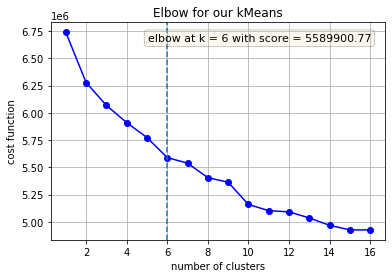

In [49]:
fig, ax = plt.subplots()
plt.plot(range(1,17), cost, '-bo')
plt.axvline(x = 6, ls = '--')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
ax.text(0.29, 0.95, "elbow at k = {} with score = {:.2f}".format(6, cost[5]), transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)
plt.title('Elbow for our kMeans')
plt.xlabel('number of clusters')
plt.ylabel('cost function')
plt.grid(True)

From this plot we can say that the optimal number of cluster is k = 6, why after the k = 6 the cost function decrese more slowly.

__Silhoutte score analysis:__ 

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [48]:
Silhoutte_score = []
for i in range(2, 13):
    model = KMeans(n_clusters=i,  init='k-means++', random_state=42)
    model.fit(Principal)
    score = silhouette_score(Principal, model.labels_)
    Silhoutte_score.append(score)
    print("Number clusters: {}, Silhouette score is {}".format(i, score))

Number clusters: 2, Silhouette score is 0.07547676964414408
Number clusters: 3, Silhouette score is 0.047413485788130136
Number clusters: 4, Silhouette score is 0.04806415912329984
Number clusters: 5, Silhouette score is 0.0411374784412609
Number clusters: 6, Silhouette score is 0.03542525227382431
Number clusters: 7, Silhouette score is 0.03816339500890499
Number clusters: 8, Silhouette score is 0.029784076489197443
Number clusters: 9, Silhouette score is 0.02998535866033167
Number clusters: 10, Silhouette score is 0.030103784616717744
Number clusters: 11, Silhouette score is 0.030041342815349068
Number clusters: 12, Silhouette score is 0.030774042011984352


From the Elbow and the Silhoutte score we decide that the best number of cluster is k = 6.

### Run the algorithm on the data that you got from the dimensionality reduction

In [6]:
C, u, dist = Kmeans(Principal, 6)

In [7]:
print(dist)

5733125.560294749


Now I will assign to each row of the dataset its calculated cluster

In [8]:
cluster = np.zeros(Principal.shape[0], dtype = np.int64)

In [9]:
for clust,lis in C.items():
    for value in lis:
        cluster[value] = clust

In [10]:
print(np.unique(cluster))

[0 1 2 3 4 5]


### True kmeans ++ 

In [71]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [61]:
our_model = KMeans(init = 'k-means++', random_state = 42)

In [63]:
visualizer = KElbowVisualizer(our_model, k = (2,20), metric = "distortion", timings = False)

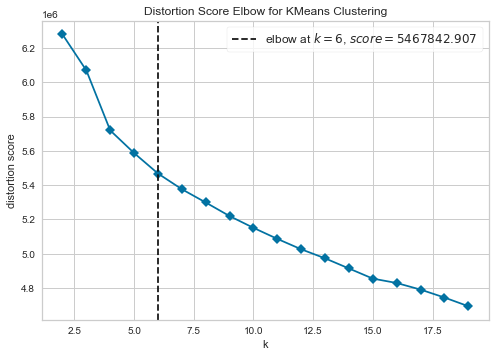

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [64]:
visualizer.fit(Principal)
visualizer.show()

__our kmeans vs optimazed one__:

with respect to our Kmeans this elbow suggests the same number of clusters, as we can see from the slowdown of the cost of the solution after six clusters, but it is less segmented and this is due to the fact that Kmeans ++ reduces randomness of the Kmeans's solution so the descent of the cost of the solution is cleaner.

## [2.4] Analysing your results!

### Selecting the variable relevant to identify the genre of a song

```
variable = [energy_features , 
            track_duration,
            track_bit_rate,
            acousticness_feateure,
            track_listens,
            Country, 
            track_language_code]
```

### If any of your selected variables are numerical (continuous or discrete), then categorize them into 4 categories

We catagorize the numerical variables in 4 categories based from the quantile of those variables

In [12]:
def classify_range(row, quintile):
    if row <= quintile[0]:
        return 1
    if row <= quintile[1]:
        return 2
    if row <= quintile[2]:
        return 3
    if row >= quintile[2]:
        return 4

In [199]:
df['track_duration'].describe()

count    13129.000000
mean       273.829385
std        371.122381
min          0.000000
25%        137.000000
50%        200.000000
75%        289.000000
max      18350.000000
Name: track_duration, dtype: float64

In [202]:
quintile_duration = list(df['track_duration'].describe()[4:7])
duration_cluster = df['track_duration'].apply(lambda row: classify_range(row, quintile_duration))
np.unique(duration_cluster)

array([1, 2, 3, 4], dtype=int64)

In [196]:
quintile_listens = list(df['track_listens'].describe()[4:7])
listens_cluster = df['track_listens'].apply(lambda row: classify_range(row, quintile_listens))

In [197]:
quintile_acousticness = list(df['audio_features_acousticness'].describe()[4:7])
acousticness_cluster = df['audio_features_acousticness'].apply(lambda row: classify_range(row, quintile_acousticness))

In [13]:
quintile_bit = list(df['track_bit_rate'].describe()[4:7])
bit_cluster = df['track_bit_rate'].apply(lambda row: classify_range(row, quintile_bit))

In [203]:
quintile_energy = list(df['audio_features_energy'].describe()[4:7])
energy_cluster = df['audio_features_energy'].apply(lambda row: classify_range(row, quintile_energy))

### With the selected variables, perform pivot tables.

In [206]:
variable = [energy_cluster,duration_cluster,bit_cluster,acousticness_cluster,listens_cluster, df['Country'], df['track_language_code']]
name_var = ['energy feature','duration track','bit rate','acousticness feature','listens track', 'Country', 'Language']

Pivot_table = []

for var,name in zip(variable,name_var):
    Pivot_table.append(pd.crosstab(index = var, columns = cluster, rownames = [name],
           colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0).sort_values(by = 1, ascending=False))

In [222]:
from IPython.display import display

In [224]:
for i in range(len(Pivot_table)):
    display(Pivot_table[i])

clusters,0,1,2,3,4,5
energy feature,,,,,,
4,18.30,61.61,23.31,25.52,12.92,29.41
3,26.19,22.33,25.91,26.26,24.44,41.18
2,26.48,9.15,27.24,25.60,29.86,23.53
1,29.04,6.91,23.55,22.63,32.77,5.88


clusters,0,1,2,3,4,5
duration track,,,,,,
4,35.32,26.11,25.77,10.07,21.06,11.76
3,26.81,25.86,25.05,13.46,26.43,17.65
2,21.22,25.61,26.56,18.58,27.85,23.53
1,16.65,22.43,22.62,57.89,24.66,47.06


clusters,0,1,2,3,4,5
bit rate,,,,,,
2,36.34,48.38,44.33,42.69,46.97,76.47
1,40.32,35.41,40.74,42.36,36.56,5.88
4,23.34,16.21,14.94,14.95,16.47,17.65


clusters,0,1,2,3,4,5
acousticness feature,,,,,,
1,21.73,36.25,26.59,23.37,21.18,17.65
2,25.82,23.97,26.18,24.86,24.16,29.41
3,24.91,22.97,24.50,26.92,25.77,35.29
4,27.54,16.81,22.73,24.86,28.89,17.65


clusters,0,1,2,3,4,5
listens track,,,,,,
2,22.90,27.65,20.13,27.99,27.64,35.29
1,24.58,25.71,17.98,33.86,27.33,29.41
3,25.60,23.72,25.91,21.80,25.34,35.29
4,26.92,22.92,35.99,16.35,19.69,0.00


clusters,0,1,2,3,4,5
Country,,,,,,
United States,41.20,53.75,43.20,43.44,41.15,52.94
NA,28.05,20.34,24.81,26.67,27.73,35.29
United Kingdom,6.14,6.02,7.48,7.60,7.71,5.88
France,2.78,2.64,2.32,2.06,2.63,0.00
Deutschland,3.14,2.19,2.39,2.56,2.56,0.00
...,...,...,...,...,...,...
Magyarország,0.04,0.00,0.03,0.00,0.28,0.00
Lëtzebuerg,0.04,0.00,0.00,0.00,0.02,0.00
Lietuva,0.00,0.00,0.00,0.08,0.09,0.00


clusters,0,1,2,3,4,5
Language,,,,,,
en,96.97,98.51,96.55,98.84,97.47,100.0
es,1.10,0.80,0.44,0.08,0.83,0.0
sr,0.00,0.25,0.03,0.00,0.28,0.0
fr,0.47,0.20,0.41,0.33,0.24,0.0
hi,0.00,0.05,0.07,0.00,0.00,0.0
ar,0.00,0.05,0.34,0.00,0.00,0.0
de,0.07,0.05,0.03,0.00,0.00,0.0
it,0.11,0.05,0.17,0.00,0.17,0.0
tr,0.11,0.05,0.21,0.17,0.31,0.0


### Calculate the percentage by column for each pivot table

In [228]:
prova = Pivot_table[0]
prova

clusters,0,1,2,3,4,5
energy feature,,,,,,
4,18.30,61.61,23.31,25.52,12.92,29.41
3,26.19,22.33,25.91,26.26,24.44,41.18
2,26.48,9.15,27.24,25.60,29.86,23.53
1,29.04,6.91,23.55,22.63,32.77,5.88


In [235]:
np.sum(pivot)

clusters
0    100.01
1    100.00
2    100.01
3    100.01
4     99.99
5    100.00
dtype: float64

In [236]:
for pivot, name in zip(Pivot_table, name_var):
    print("Sum for pivot table {} is: ".format(name), pivot.sum())

Sum for pivot table energy feature is:  clusters
0    100.01
1    100.00
2    100.01
3    100.01
4     99.99
5    100.00
dtype: float64
Sum for pivot table duration track is:  clusters
0    100.00
1    100.01
2    100.00
3    100.00
4    100.00
5    100.00
dtype: float64
Sum for pivot table bit rate is:  clusters
0    100.00
1    100.00
2    100.01
3    100.00
4    100.00
5    100.00
dtype: float64
Sum for pivot table acousticness feature is:  clusters
0    100.00
1    100.00
2    100.00
3    100.01
4    100.00
5    100.00
dtype: float64
Sum for pivot table listens track is:  clusters
0    100.00
1    100.00
2    100.01
3    100.00
4    100.00
5     99.99
dtype: float64
Sum for pivot table Country is:  clusters
0    100.05
1    100.02
2     99.97
3     99.98
4     99.95
5     99.99
dtype: float64
Sum for pivot table Language is:  clusters
0    100.00
1    100.01
2     99.94
3     99.99
4     99.99
5    100.00
dtype: float64


We don't obtain the 100% for each columns and this is most because of the approximation number the pivot table does.

### Interpret the results for each pivot table

Speaking about energy feature, here the observations are almost equally distributed in clusters, except for the first and fifth clusters (we enumerate clusters from 0 to 6) because in the first the 60% of observations that belong to the cluster come from the fourth modality of the feature and in the fifth the 40% of observations that belong to the cluster come from the third modality of the feature.

Speaking about duration track feature, here the observations are almost equally distributed in clusters, except for the third and fifth clusters because in the third the 58% of observations that belong to the cluster come from the first modality of the feature and in the fifth the 47% of observations that belong to the cluster come from the first modality of the feature.

Speaking about bit rate feature, to the low number of data in this feature we categorize them only in 3 group but the observations are almost eually distributed in clusters.

Speaking about acousticness feature feature, here the observations are almost equally distributed in clusters so its not the best feature to classify by genre.

Speaking about listens track feature, here the observations are almost equally distributed in clusters, except for the fifth because here the observations that belong to this cluster are only the observations that belongs to the first three modality of the variable.

Speaking about country feature, here a range from 70 to 80 % of cluster membership comes from two country and the most important is USA. 

Speaking about language feature, here almost all the observations of all clusters belong to a single modality of the variable.

### Compare with the true genre

Us it to answer what is the most representative genre for each one of the clusters

In [242]:
Genre_pivot = pd.crosstab(index = df['track_genre_top'], columns = cluster, rownames = ['Genre'],
                   colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0)
display(Genre_pivot)

clusters,0,1,2,3,4,5
Genre,,,,,,
Blues,0.29,0.40,0.72,0.00,0.43,0.00
Classical,0.37,0.25,4.85,0.00,0.02,0.00
Country,0.62,0.85,0.68,0.08,0.85,0.00
Easy Listening,0.00,0.05,0.00,0.00,0.00,0.00
Electronic,15.45,9.05,3.69,16.10,7.52,23.53
Experimental,12.20,9.35,7.69,18.41,9.42,11.76
Folk,1.83,4.43,14.63,2.39,2.34,0.00
Hip-Hop,8.91,5.07,0.21,0.66,3.64,0.00
Instrumental,0.77,0.65,1.30,1.32,0.95,11.76


We can see that a lot of the clustering is on the Not Available genre because infact is the: 35% of the data we have

In [251]:
(df['track_genre_top'] == 'NA').sum() / df.shape[0] * 100

34.7170386168025

So we decide to exclude and view only the genre we have left: 

In [252]:
# drop the 'NA' rows and find the maximum
Genre_pivot_2 = Genre_pivot.drop('NA', axis = 0)
max_value = np.max(Genre_pivot, axis = 0)

In [259]:
Genre_pivot_2.idxmax(axis = 0)

clusters
0    Electronic
1          Rock
2          Folk
3          Rock
4          Rock
5    Electronic
dtype: object

As we can see for the cluster 0 is mainly composed by NA and eletronic genres, the cluster 1 is mainly composed by Rock genre, the cluster 2 is mainly composed by NA and Folk genres, the cluster 3 is mainly composed by Rock, NA and Experimental genres, the cluster 4 is mainly composed by NA and Rock genres and the fifth cluster is mainly composed by NA and Eletronic genres.

## Execute your K-means++ Analysis again, but don't use the variables from echonest.csv. It will leave you with ~100K songs

Do:

* Perform the dimensionality reduction.
* Find the optimal number of clusters.
* Characterize your clusters using 5-10 variables.
* Compare your results with those of the previous exercise. If you could choose, would you rather collect more observations (with fewer features) or fewer observations (with more features) based on the previous analyses?

In [269]:
features = pd.read_csv('features.csv')

In [270]:
tracks = pd.read_csv('tracks.csv')

In [271]:
df2 = pd.concat([features, tracks], axis=1, join = 'inner')

In [272]:
del features
del tracks

Polish the dataset

In [273]:
Missing_value = df2.isna().sum() / df2.shape[0]

In [274]:
MISS = Missing_value[Missing_value > 0].sort_values(ascending = False)
MISS_cols = list(MISS.index.values)
print(MISS)

track_lyricist              0.997082
track_publisher             0.988149
track_information           0.977959
track_composer              0.965564
artist_active_year_end      0.949566
artist_wikipedia_page       0.947633
track_date_recorded         0.942209
artist_related_projects     0.876593
artist_associated_labels    0.866093
track_language_code         0.859028
album_engineer              0.856485
album_producer              0.830540
artist_active_year_begin    0.786899
artist_longitude            0.582037
artist_latitude             0.582037
artist_members              0.560409
track_genre_top             0.534614
artist_location             0.341209
album_date_released         0.340421
artist_bio                  0.332332
artist_website              0.256329
album_information           0.219800
album_type                  0.061066
album_date_created          0.033113
album_title                 0.009618
artist_date_created         0.008032
track_license               0.000816
t

In [276]:
MISS_cols.remove('track_language_code')
MISS_cols.remove('track_genre_top')
print(MISS_cols)

['track_lyricist', 'track_publisher', 'track_information', 'track_composer', 'artist_active_year_end', 'artist_wikipedia_page', 'track_date_recorded', 'artist_related_projects', 'artist_associated_labels', 'album_engineer', 'album_producer', 'artist_active_year_begin', 'artist_longitude', 'artist_latitude', 'artist_members', 'artist_location', 'album_date_released', 'artist_bio', 'artist_website', 'album_information', 'album_type', 'album_date_created', 'album_title', 'artist_date_created', 'track_license', 'track_title']


In [277]:
df2 = df2.drop(columns = MISS_cols)

In [293]:
Empty_values = (df2 == '[]' ).sum(axis = 0) / df2.shape[0] 

In [294]:
EMPTY = Empty_values[Empty_values > 0].sort_values(ascending = False)
EMPTY_cols = list(EMPTY.index.values)
print(EMPTY)

album_tags    0.783953
track_tags    0.779533
dtype: float64


In [295]:
df2 = df2.drop(columns = EMPTY_cols)

In [296]:
df2 = df2.loc[:,~df2.columns.duplicated()]  # removing duplicate columns

In [305]:
toDrop = ['set_split', 'set_subset', 'track_date_created', 'artist_name', 'track_number', 'artist_id', 'album_id', 'track_id', 'track_genre_top']
toStore = ['track_language_code']

__Perform the dimensionality reduction.__

In [306]:
PCA2_tmp = df2.copy()
PCA2_tmp = PCA2_tmp.drop(columns = toDrop)

In [307]:
PCA2_tmp = PCA2_tmp.fillna('NA')
language = PCA2_tmp["track_language_code"].unique()

In [308]:
language_parser = dict(zip(language, range(len(language))))
print(language_parser)

{'en': 0, 'es': 1, 'NA': 2, 'fi': 3, 'pt': 4, 'tr': 5, 'sw': 6, 'el': 7, 'ar': 8, 'pl': 9, 'id': 10, 'tw': 11, 'eu': 12, 'ms': 13, 'fr': 14, 'ty': 15, 'hy': 16, 'hi': 17, 'vi': 18, 'ja': 19, 'tl': 20, 'it': 21, 'my': 22, 'gu': 23, 'zh': 24, 'uk': 25, 'az': 26, 'sr': 27, 'lt': 28, 'th': 29, 'bg': 30, 'de': 31, 'no': 32, 'ko': 33, 'uz': 34, 'ka': 35, 'ha': 36, 'sk': 37, 'nl': 38, 'bm': 39, 'ru': 40, 'he': 41, 'cs': 42, 'la': 43, 'ee': 44}


In [309]:
for i in tqdm(range(PCA2_tmp.shape[0])):
    PCA2_tmp.loc[i, "track_language_code"] = language_parser[PCA2_tmp.track_language_code.loc[i]]

100%|█████████████████████████████████████████████████████████████████████████| 106574/106574 [02:34<00:00, 691.81it/s]


In [310]:
Store = PCA2_tmp['track_language_code']
PCA2_tmp2 = PCA2_tmp.drop(columns = 'track_language_code')

In [311]:
PCA2_tmp2.head(2)

,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,chroma_cens_median_05,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_median_08,chroma_cens_median_09,chroma_cens_median_10,chroma_cens_median_11,chroma_cens_median_12,chroma_cens_min_01,chroma_cens_min_02,chroma_cens_min_03,chroma_cens_min_04,chroma_cens_min_05,chroma_cens_min_06,chroma_cens_min_07,chroma_cens_min_08,chroma_cens_min_09,chroma_cens_min_10,chroma_cens_min_11,chroma_cens_min_12,chroma_cens_skew_01,chroma_cens_skew_02,chroma_cens_skew_03,chroma_cens_skew_04,chroma_cens_skew_05,chroma_cens_skew_06,chroma_cens_skew_07,chroma_cens_skew_08,chroma_cens_skew_09,chroma_cens_skew_10,chroma_cens_skew_11,chroma_cens_skew_12,chroma_cens_std_01,chroma_cens_std_02,chroma_cens_std_03,chroma_cens_std_04,chroma_cens_std_05,chroma_cens_std_06,chroma_cens_std_07,chroma_cens_std_08,chroma_cens_std_09,chroma_cens_std_10,chroma_cens_std_11,chroma_cens_std_12,chroma_cqt_kurtosis_01,chroma_cqt_kurtosis_02,chroma_cqt_kurtosis_03,chroma_cqt_kurtosis_04,chroma_cqt_kurtosis_05,chroma_cqt_kurtosis_06,chroma_cqt_kurtosis_07,chroma_cqt_kurtosis_08,chroma_cqt_kurtosis_09,chroma_cqt_kurtosis_10,chroma_cqt_kurtosis_11,chroma_cqt_kurtosis_12,chroma_cqt_max_01,chroma_cqt_max_02,chroma_cqt_max_03,chroma_cqt_max_04,chroma_cqt_max_05,chroma_cqt_max_06,chroma_cqt_max_07,chroma_cqt_max_08,chroma_cqt_max_09,chroma_cqt_max_10,chroma_cqt_max_11,chroma_cqt_max_12,chroma_cqt_mean_01,chroma_cqt_mean_02,chroma_cqt_mean_03,chroma_cqt_mean_04,chroma_cqt_mean_05,chroma_cqt_mean_06,chroma_cqt_mean_07,chroma_cqt_mean_08,chroma_cqt_mean_09,chroma_cqt_mean_10,chroma_cqt_mean_11,chroma_cqt_mean_12,chroma_cqt_median_01,chroma_cqt_median_02,chroma_cqt_median_03,chroma_cqt_median_04,chroma_cqt_median_05,chroma_cqt_median_06,chroma_cqt_median_07,chroma_cqt_median_08,chroma_cqt_median_09,chroma_cqt_median_10,chroma_cqt_median_11,chroma_cqt_median_12,chroma_cqt_min_01,chroma_cqt_min_02,chroma_cqt_min_03,chroma_cqt_min_04,chroma_cqt_min_05,chroma_cqt_min_06,chroma_cqt_min_07,chroma_cqt_min_08,chroma_cqt_min_09,chroma_cqt_min_10,chroma_cqt_min_11,chroma_cqt_min_12,chroma_cqt_skew_01,chroma_cqt_skew_02,chroma_cqt_skew_03,chroma_cqt_skew_04,chroma_cqt_skew_05,chroma_cqt_skew_06,chroma_cqt_skew_07,chroma_cqt_skew_08,chroma_cqt_skew_09,chroma_cqt_skew_10,chroma_cqt_skew_11,chroma_cqt_skew_12,chroma_cqt_std_01,chroma_cqt_std_02,chroma_cqt_std_03,chroma_cqt_std_04,chroma_cqt_std_05,chroma_cqt_std_06,chroma_cqt_std_07,chroma_cqt_std_08,chroma_cqt_std_09,chroma_cqt_std_10,chroma_cqt_std_11,chroma_cqt_std_12,chroma_stft_kurtosis_01,chroma_stft_kurtosis_02,chroma_stft_kurtosis_03,chroma_stft_kurtosis_04,chroma_stft_kurtosis_05,chroma_stft_kurtosis_06,chroma_stft_kurtosis_07,chroma_stft_kurtosis_08,chroma_stft_kurtosis_09,chroma_stft_kurtosis_10,chroma_stft_kurtosis_11,chroma_stft_kurtosis_12,chroma_stft_max_01,chroma_stft_max_02,chroma_stft_max_03,chroma_stft_max_04,chroma_stft_max_05,chroma_stft_max_06,chroma_stft_max_07,chroma_stft_max_08,chroma_stft_max_09,chroma_stft_max_10,chroma_stft_max_11,chroma_stft_max_12,chroma_stft_mean_01,chroma_stft_mean_02,chroma_stft_mean_03,chroma_stft_mean_04,chroma_stft_mean_05,chroma_stft_mean_06,chroma_stft_mea

In [312]:
from sklearn.decomposition import PCA

In [313]:
#standardize my data
PCA2_norm = PCA2_tmp2.copy()
PCA2_norm = (PCA2_norm - PCA2_norm.mean())/PCA2_norm.std()

In [314]:
c = PCA2_norm.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")

In [315]:
# remove high correlation variables 

HighCorr = so[-560:-531].index.values
toDropHighCorr = list(sum(HighCorr, ()))
toDropHighCorr = list(set(toDropHighCorr))

In [316]:
PCA2_norm = PCA2_norm.drop(columns = toDropHighCorr)

In [317]:
PCA2_norm.shape

(106574, 500)

In [324]:
pca = PCA(n_components=51) #how we can see from the next cell the number of principal components needed to explain at least 70 percent of the total variance in the starting dataset is 76
principalcompo = pca.fit_transform(PCA2_norm)
principal = pd.DataFrame(data = principalcompo)    
#principal

In [325]:
print('the percentage of variance explained by the principal components is',sum(pca.explained_variance_ratio_)*100)

the percentage of variance explained by the principal components is 70.13607115865972


__Find the optimal number of clusters__

In [326]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [327]:
our_model = KMeans(init = 'k-means++')

In [328]:
visualizer = KElbowVisualizer(our_model, k = (2,20), metric = "distortion", timings = False)

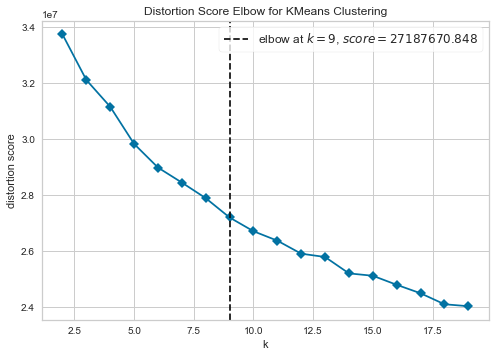

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [329]:
visualizer.fit(principal)
visualizer.show()

Perform the kMeans ++ with K = 9

In [330]:
model = KMeans(n_clusters = 9, init = 'k-means++', random_state = 42)

In [331]:
model.fit(principal)

KMeans(n_clusters=9, random_state=42)

In [332]:
y_true = model.predict(principal)

__Characterize your clusters using 5-10 variables__

```
variable = [track_duration,
            track_bit_rate,
            track_listens,
            track_interest,
            track_language_code]
```

In [241]:
variable = ['track_duration', 'track_language_code', 'track_listens', 'track_bit_rate']

In [341]:
quintile_listens = list(df2['track_listens'].describe()[4:7])
listens_cluster = df2['track_listens'].apply(lambda row: classify_range(row, quintile_listens))

In [338]:
quintile_bit = list(df2['track_bit_rate'].describe()[4:7])
bit_cluster = df2['track_bit_rate'].apply(lambda row: classify_range(row, quintile_bit))

In [339]:
quintile_duration = list(df2['track_duration'].describe()[4:7])
duration_cluster = df2['track_duration'].apply(lambda row: classify_range(row, quintile_duration))

In [340]:
quintile_interest = list(df2['track_interest'].describe()[4:7])
interest_cluster = df2['track_interest'].apply(lambda row: classify_range(row, quintile_interest))

In [342]:
df2['track_language_code'] = df2['track_language_code'].fillna('NA')

In [344]:
variable = [duration_cluster, listens_cluster, df2['track_language_code'], bit_cluster, interest_cluster] 
name_var = ['duration track','listens track', 'Language', 'bit rate', 'track interest']

Pivot_table2 = []
for var,name in zip(variable,name_var):
    Pivot_table2.append(pd.crosstab(index = var, columns = y_true, rownames = [name],
           colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0))

In [346]:
for i in range(len(Pivot_table2)):
    display(Pivot_table2[i])

clusters,0,1,2,3,4,5,6,7,8
duration track,,,,,,,,,
1,18.24,57.15,24.09,18.53,15.69,40.0,34.51,47.14,31.09
2,26.48,16.05,19.43,23.41,23.60,20.0,25.24,14.29,29.11
3,29.78,13.61,21.50,28.73,29.08,20.0,18.55,12.86,22.08
4,25.50,13.19,34.98,29.33,31.63,20.0,21.71,25.71,17.72


clusters,0,1,2,3,4,5,6,7,8
listens track,,,,,,,,,
1,20.07,33.18,20.83,24.33,25.49,40.0,21.55,11.43,31.00
2,22.72,28.69,20.81,26.28,25.29,40.0,21.77,35.71,28.04
3,26.80,22.47,25.73,26.23,25.29,20.0,23.06,31.43,23.54
4,30.40,15.66,32.63,23.16,23.93,0.0,33.62,21.43,17.42


clusters,0,1,2,3,4,5,6,7,8
Language,,,,,,,,,
NA,86.99,86.43,88.06,90.01,85.21,20.0,84.32,90.0,83.15
ar,0.01,0.00,0.02,0.00,0.01,0.0,0.04,0.0,0.00
az,0.00,0.00,0.00,0.00,0.00,0.0,0.02,0.0,0.00
bg,0.00,0.00,0.07,0.00,0.00,0.0,0.01,0.0,0.00
bm,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00
cs,0.00,0.00,0.00,0.00,0.01,0.0,0.00,0.0,0.02
de,0.10,0.02,0.27,0.02,0.02,0.0,0.09,0.0,0.02
ee,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.03
el,0.00,0.02,0.00,0.00,0.00,0.0,0.03,0.0,0.01


clusters,0,1,2,3,4,5,6,7,8
bit rate,,,,,,,,,
1,25.26,25.36,26.51,18.69,25.33,0.0,29.30,15.71,27.04
2,26.08,25.46,21.35,17.72,20.79,60.0,24.62,30.00,30.72
3,48.31,48.37,51.63,62.99,53.39,40.0,45.69,52.86,41.76
4,0.35,0.81,0.51,0.61,0.49,0.0,0.40,1.43,0.47


clusters,0,1,2,3,4,5,6,7,8
track interest,,,,,,,,,
1,20.70,32.55,20.79,24.42,24.53,0.0,20.56,20.00,31.40
2,22.45,28.73,21.87,25.81,25.68,60.0,22.74,28.57,27.69
3,26.57,23.22,25.63,26.18,25.05,20.0,23.67,30.00,23.60
4,30.28,15.50,31.71,23.58,24.74,20.0,33.03,21.43,17.31


Genre:

In [347]:
df2['track_genre_top'] = df2['track_genre_top'].fillna('NA')

In [349]:
Genre_pivot2 = pd.crosstab(index = df2['track_genre_top'], columns = y_true, rownames = ['Genre'],
                   colnames = ['clusters']).apply(lambda row: round(row/row.sum()*100,2), axis = 0)
display(Genre_pivot2)

clusters,0,1,2,3,4,5,6,7,8
Genre,,,,,,,,,
Blues,0.21,0.00,0.15,0.03,0.07,0.0,0.12,0.00,0.07
Classical,0.43,0.02,5.70,0.05,0.13,0.0,5.01,0.00,0.08
Country,0.39,0.08,0.06,0.04,0.08,0.0,0.08,0.00,0.26
Easy Listening,0.03,0.00,0.03,0.01,0.05,0.0,0.03,0.00,0.00
Electronic,5.51,9.67,5.21,17.30,16.24,0.0,3.59,10.00,5.00
Experimental,6.64,20.42,11.81,9.87,11.32,0.0,10.36,7.14,9.02
Folk,6.19,0.55,3.36,0.40,0.63,0.0,5.03,0.00,1.27
Hip-Hop,1.34,1.22,0.52,5.58,9.08,0.0,0.23,0.00,2.38
Instrumental,2.51,1.71,3.35,0.91,0.74,0.0,5.13,2.86,1.05


Because we have a lot of more rows we have: 54% of missing data on the genre of a track, we do as before.

In [352]:
(df2['track_genre_top'] == 'NA').sum() / df2.shape[0] * 100

53.461444630022335

In [350]:
Genre_pivot2_2 = Genre_pivot2.drop('NA', axis = 0)

In [351]:
Genre_pivot2_2.idxmax(axis = 0)

clusters
0            Rock
1    Experimental
2    Experimental
3      Electronic
4      Electronic
5           Blues
6    Experimental
7      Electronic
8            Rock
dtype: object

# EXERCISE [3] Algorithmic questions

You are given a list of integers, *A*, and another integer *s*. Write an algorithm that outputs all the pairs in *A* that equal *x*.

For example, if
```
A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] and s = 4
```
the algorithm should output: `(7, -3), (-2, 6), (2, 2), (3, 1)`.

### Pseudocode

```
FindPairs(A: array; s: integer)
    A <- sort(A)
    start <- 1
    end <- len(A)
    while ( start < end ):
        if ( A[start]+A[end] == s ):
            print( (A[start],A[end]): tuple )
        if ( A[start]+A[end] < s  ):
            start <- start + 1   
        else:
            end <- end -1 
```

The code is base on a binary search algorithm. 
* We first sort in crescent order the array A;
* then start our search: if the sum of the extreme pointer to the list is equal to sum we print the tuple of number, then using the ordered array we increse/decrease one of the pointer according to we are higher or lower than the target s.

__Time complexity:__
    
The python sort is $\Theta(n\log(n))$, the worst case of the while loop is when we modify only one pointer with $\mathcal{O}(n)$.
Then running cost of the algorithm  $\mathcal{O}(n\log(n))$

In [15]:
def FindPairs(A,s):
    A.sort()
    start = 0
    end = len(A)-1
    while ( start < end ):
        if (A[start]+A[end] == s):
            print( (A[start],A[end]) )
        if (A[start]+A[end] < s):
            start = start + 1
        else:
            end = end -1 
    return

### Testing 

In [16]:
A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3]
s = 4

FindPairs(A,s)

(-3, 7)
(-2, 6)
(1, 3)
(2, 2)


As we can see, leaving out the Not Available (NA) which represents most of the observations of each cluster, we can see that the first cluster is mainly Rock, the second is mainly experimental, the fourth, fifth and eight are electronic and the nineth is Rock.